In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import numpy as np
import pandas as pd
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

In [2]:
ratings = pd.read_csv("D:\\PREZENT.AI\\Collaborative filtering\\dataset\\ratings.csv")
movies = pd.read_csv("D:\\PREZENT.AI\\Collaborative filtering\\dataset\\movies.csv")
data = pd.merge(movies,ratings).drop(['genres','timestamp'],axis=1)
print(data.shape)
data.head()

(100836, 4)


,movieId,title,userId,rating
0,1,Toy Story (1995),1,4.0
1,1,Toy Story (1995),5,4.0
2,1,Toy Story (1995),7,4.5
3,1,Toy Story (1995),15,2.5
4,1,Toy Story (1995),17,4.5


In [3]:
#userRatings = data.pivot_table(index=['userId'],columns=['title'],values='rating')
#userRatings.head()
#print("Before: ",userRatings.shape)
#Remove movies which have less than 10 users who rated it
#userRatings = userRatings.dropna(thresh=10, axis=1).fillna(0,axis=1)
#print("After: ",userRatings.shape)

In [4]:
#Check the datatypes
data.dtypes

movieId      int64
title       object
userId       int64
rating     float64
dtype: object

In [5]:
data['rating'].describe().transpose()

count    100836.000000
mean          3.501557
std           1.042529
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

In [6]:
print('Number of missing values across columns: \n',data.isnull().sum())

Number of missing values across columns: 
 movieId    0
title      0
userId     0
rating     0
dtype: int64


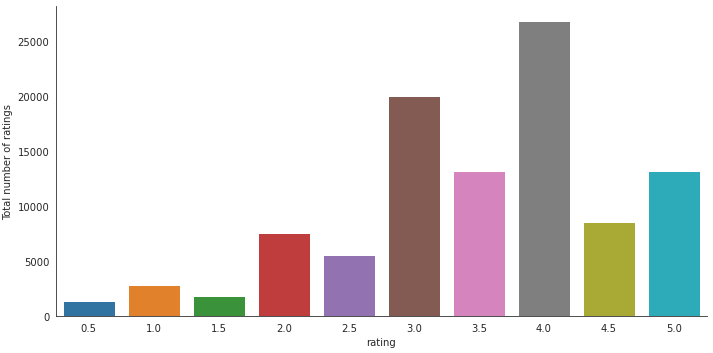

In [7]:
with sns.axes_style('white'):
    g = sns.factorplot("rating", data=data, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings") 

In [8]:
print('Number of unique users in data = ', data['userId'].nunique())
print('Number of unique product in data = ', data['movieId'].nunique())

Number of unique users in data =  610
Number of unique product in data =  9724


In [9]:
#Check the top 10 users based on ratings
most_rated=data.groupby('userId').size().sort_values(ascending=False)[:10]
print('Top 10 users based on ratings: \n',most_rated)

Top 10 users based on ratings: 
 userId
414    2698
599    2478
474    2108
448    1864
274    1346
610    1302
68     1260
380    1218
606    1115
288    1055
dtype: int64


In [10]:
counts=data.userId.value_counts()
data_final=data[data.userId.isin(counts[counts>=25].index)]
print('Number of users who have rated 25 or more items =', len(data_final))
print('Number of unique users in the final data = ', data_final['userId'].nunique())
print('Number of unique products in the final data = ', data_final['userId'].nunique())

Number of users who have rated 25 or more items = 99466
Number of unique users in the final data =  547
Number of unique products in the final data =  547


In [11]:
data_final

,movieId,title,userId,rating
0,1,Toy Story (1995),1,4.0
1,1,Toy Story (1995),5,4.0
2,1,Toy Story (1995),7,4.5
3,1,Toy Story (1995),15,2.5
4,1,Toy Story (1995),17,4.5
...,...,...,...,...
100831,193581,Black Butler: Book of the Atlantic (2017),184,4.0
100832,193583,No Game No Life: Zero (2017),184,3.5
100833,193585,Flint (2017),184,3.5
100834,193587,Bungo Stray Dogs: Dead Apple (2018),184,3.5


In [12]:
#Split the data randomnly into train and test datasets into 70:30 ratio
train_data, test_data = train_test_split(data_final, test_size = 0.3, random_state=0)
train_data.head()

,movieId,title,userId,rating
81278,40629,Pride & Prejudice (2005),280,5.0
63372,4745,O (2001),428,4.0
68332,5679,"Ring, The (2002)",600,3.5
64778,4975,Vanilla Sky (2001),139,0.5
25293,1200,Aliens (1986),186,5.0


In [13]:
print('Shape of training data: ',train_data.shape)
print('Shape of testing data: ',test_data.shape)

Shape of training data:  (69626, 4)
Shape of testing data:  (29840, 4)


Popularity recommender model

In [14]:
#Count of user_id for each unique product as recommendation score 
train_data_grouped = train_data.groupby('movieId').agg({'userId': 'count'}).reset_index()
train_data_grouped.rename(columns = {'userId': 'score'},inplace=True)
train_data_grouped.head()

,movieId,score
0,1,143
1,2,78
2,3,34
3,4,3
4,5,35


In [15]:
#Sort the products on recommendation score 
train_data_sort = train_data_grouped.sort_values(['score', 'movieId'], ascending = [0,1]) 
      
#Generate a recommendation rank based upon score 
train_data_sort['rank'] = train_data_sort['score'].rank(ascending=0, method='first') 
          
#Get the top 5 recommendations 
popularity_recommendations = train_data_sort.head(5) 
popularity_recommendations 

,movieId,score,rank
298,356,212,1.0
243,296,206,2.0
1842,2571,205,3.0
262,318,204,4.0
489,593,191,5.0


In [16]:
# Use popularity based recommender model to make predictions
def recommend(user_id):     
    user_recommendations = popularity_recommendations 
          
    #Add user_id column for which the recommendations are being generated 
    user_recommendations['userId'] = user_id 
      
    #Bring user_id column to the front 
    cols = user_recommendations.columns.tolist() 
    cols = cols[-1:] + cols[:-1] 
    user_recommendations = user_recommendations[cols] 
          
    return user_recommendations 

In [17]:
find_recom = [10,100,150]   # This list is user choice.
for i in find_recom:
    print("The list of recommendations for the userId: %d\n" %(i))
    print(recommend(i))    
    print("\n") 

The list of recommendations for the userId: 10

      userId  movieId  score  rank
298       10      356    212   1.0
243       10      296    206   2.0
1842      10     2571    205   3.0
262       10      318    204   4.0
489       10      593    191   5.0


The list of recommendations for the userId: 100

      userId  movieId  score  rank
298      100      356    212   1.0
243      100      296    206   2.0
1842     100     2571    205   3.0
262      100      318    204   4.0
489      100      593    191   5.0


The list of recommendations for the userId: 150

      userId  movieId  score  rank
298      150      356    212   1.0
243      150      296    206   2.0
1842     150     2571    205   3.0
262      150      318    204   4.0
489      150      593    191   5.0




Since, it is a Popularity recommender model, so, all the three users are given the same recommendations. Here, we predict the products based on the popularity. It is not personalized to particular user. It is a non-personalized recommender system.

Collaborative filtering model

In [18]:
data_CF = pd.concat([train_data, test_data]).reset_index()
data_CF.head()

,index,movieId,title,userId,rating
0,81278,40629,Pride & Prejudice (2005),280,5.0
1,63372,4745,O (2001),428,4.0
2,68332,5679,"Ring, The (2002)",600,3.5
3,64778,4975,Vanilla Sky (2001),139,0.5
4,25293,1200,Aliens (1986),186,5.0


User based CF

In [19]:
# Matrix with row per 'user' and column per 'movie' 
pivot_df = data_CF.pivot(index = 'userId', columns ='movieId', values = 'rating').fillna(0)
pivot_df.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
print('Shape of the pivot table: ', pivot_df.shape)

Shape of the pivot table:  (547, 9710)


In [21]:
pivot_df['user_index'] = np.arange(0, pivot_df.shape[0], 1)
pivot_df.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193567,193571,193573,193579,193581,193583,193585,193587,193609,user_index
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


In [22]:
pivot_df.set_index(['user_index'], inplace=True)
# Actual ratings given by users
pivot_df.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
user_index,,,,,,,,,,,,,,,,,,,,,
0,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Since sparsity and scalability are the two biggest challenges for standard CF method, it comes a more advanced method that decompose the original sparse matrix to low-dimensional matrices with latent factors/features and less sparsity. That is Matrix Factorization.
To see how a matrix being factorized, first thing to understand is Singular Value Decomposition(SVD)
Refer: https://towardsdatascience.com/intro-to-recommender-system-collaborative-filtering-64a238194a26

In [23]:
# Singular Value Decomposition
U, sigma, Vt = svds(pivot_df, k = 10)

In [24]:
print('Left singular matrix: \n',U)

Left singular matrix: 
 [[ 0.02169849  0.03262919 -0.0058862  ...  0.01323852  0.0618685
  -0.05558133]
 [ 0.01530573  0.01992618  0.00827268 ...  0.00388345 -0.01777685
  -0.00586661]
 [-0.00079018 -0.00223364  0.00034329 ... -0.00162511  0.00210128
  -0.00135629]
 ...
 [-0.02787355 -0.00716524  0.00682664 ...  0.01333108  0.01204556
  -0.11627146]
 [ 0.00387616 -0.00434947 -0.00376991 ...  0.03938246  0.01321078
  -0.0075442 ]
 [ 0.07535058 -0.18311654 -0.22319791 ... -0.09901666 -0.20200959
  -0.13909936]]


In [25]:
print('Sigma: \n',sigma)

Sigma: 
 [113.00824441 121.2925384  122.27583761 135.57290102 146.710169
 154.28281524 169.59798121 189.37376675 230.86309413 533.86338287]


In [26]:
# Construct diagonal array in SVD
sigma = np.diag(sigma)
print('Diagonal matrix: \n',sigma)

Diagonal matrix: 
 [[113.00824441   0.           0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.         121.2925384    0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.         122.27583761   0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.           0.         135.57290102   0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.         146.710169
    0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
  154.28281524   0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
    0.         169.59798121   0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
    0.           0.        

In [27]:
print('Right singular matrix: \n',Vt)

Right singular matrix: 
 [[ 1.25709854e-02  2.52643788e-03  1.70384222e-02 ... -3.63986379e-04
  -3.63986379e-04  1.18602104e-03]
 [ 1.01042798e-02 -2.70252823e-02  2.69055533e-02 ...  3.97320669e-05
   3.97320669e-05  6.18938561e-04]
 [-1.64157186e-02 -3.29197769e-02 -4.06907673e-03 ...  5.14835117e-04
   5.14835117e-04  4.41156879e-04]
 ...
 [ 8.01508346e-02  5.89894818e-02  1.93397809e-02 ... -1.09235479e-04
  -1.09235479e-04  8.62281263e-05]
 [ 2.66608770e-02  1.63609226e-03  2.45189458e-02 ... -5.99259165e-04
  -5.99259165e-04 -1.27722802e-03]
 [-7.04024222e-02 -3.85818360e-02 -1.59059232e-02 ... -6.48608275e-05
  -6.48608275e-05 -2.72289397e-04]]


In [28]:
#Predicted ratings
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
# Convert predicted ratings to dataframe
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = pivot_df.columns)
preds_df.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
0,2.854034,0.932421,0.965916,-0.019408,0.199461,1.702076,0.097137,-0.002959,0.137962,2.004843,...,-0.012601,-0.010801,-0.014401,-0.014401,-0.012601,-0.014401,-0.012601,-0.012601,-0.012601,-0.019453
1,0.199780,-0.002251,-0.025131,0.003600,0.028547,0.094732,-0.053993,0.012754,-0.011331,-0.074697,...,0.005924,0.005078,0.006771,0.006771,0.005924,0.006771,0.005924,0.005924,0.005924,0.013176
2,0.031076,0.016078,0.018865,-0.004284,-0.016214,0.078336,-0.013848,0.000268,0.007222,0.064065,...,0.000242,0.000207,0.000276,0.000276,0.000242,0.000276,0.000242,0.000242,0.000242,-0.001902
3,1.575560,0.226482,0.277708,0.056291,0.185229,0.256445,0.326909,-0.054199,-0.017671,0.086457,...,-0.001759,-0.001507,-0.002010,-0.002010,-0.001759,-0.002010,-0.001759,-0.001759,-0.001759,-0.010022
4,1.287108,1.004904,0.434498,0.129786,0.549065,0.779558,0.649015,0.120401,0.120460,1.124042,...,0.000588,0.000504,0.000672,0.000672,0.000588,0.000672,0.000588,0.000588,0.000588,-0.000167


In [29]:
# Recommend the items with the highest predicted ratings

def recommend_items(userID, pivot_df, preds_df, num_recommendations):
    # index starts at 0  
    user_idx = userID-1 
    # Get and sort the user's ratings
    sorted_user_ratings = pivot_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_ratings
    sorted_user_predictions = preds_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_predictions
    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1)
    temp.index.name = 'Recommended Items'
    temp.columns = ['user_ratings', 'user_predictions']
    temp = temp.loc[temp.user_ratings == 0]   
    temp = temp.sort_values('user_predictions', ascending=False)
    print('\nBelow are the recommended items for user(user_id = {}):\n'.format(userID))
    print(temp.head(num_recommendations))

In [30]:
userID = 4
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations) 


Below are the recommended items for user(user_id = 4):

                   user_ratings  user_predictions
Recommended Items                                
858                         0.0          2.195374
1247                        0.0          2.090157
1307                        0.0          2.083549
1208                        0.0          2.040644
2396                        0.0          2.015638


In [31]:
userID = 6
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 6):

                   user_ratings  user_predictions
Recommended Items                                
300                         0.0          3.951077
648                         0.0          3.544253
39                          0.0          3.341900
1                           0.0          3.232801
442                         0.0          2.872964


In [32]:
userID = 8
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 8):

                   user_ratings  user_predictions
Recommended Items                                
588                         0.0          2.367649
165                         0.0          2.313928
161                         0.0          2.272230
349                         0.0          2.260219
589                         0.0          2.235292


In [33]:
# Actual ratings given by the users
pivot_df.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
user_index,,,,,,,,,,,,,,,,,,,,,
0,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
pivot_df.mean().head()

movieId
1    1.506399
2    0.684644
3    0.299817
4    0.030165
5    0.259598
dtype: float64

In [35]:
preds_df.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
0,2.854034,0.932421,0.965916,-0.019408,0.199461,1.702076,0.097137,-0.002959,0.137962,2.004843,...,-0.012601,-0.010801,-0.014401,-0.014401,-0.012601,-0.014401,-0.012601,-0.012601,-0.012601,-0.019453
1,0.199780,-0.002251,-0.025131,0.003600,0.028547,0.094732,-0.053993,0.012754,-0.011331,-0.074697,...,0.005924,0.005078,0.006771,0.006771,0.005924,0.006771,0.005924,0.005924,0.005924,0.013176
2,0.031076,0.016078,0.018865,-0.004284,-0.016214,0.078336,-0.013848,0.000268,0.007222,0.064065,...,0.000242,0.000207,0.000276,0.000276,0.000242,0.000276,0.000242,0.000242,0.000242,-0.001902
3,1.575560,0.226482,0.277708,0.056291,0.185229,0.256445,0.326909,-0.054199,-0.017671,0.086457,...,-0.001759,-0.001507,-0.002010,-0.002010,-0.001759,-0.002010,-0.001759,-0.001759,-0.001759,-0.010022
4,1.287108,1.004904,0.434498,0.129786,0.549065,0.779558,0.649015,0.120401,0.120460,1.124042,...,0.000588,0.000504,0.000672,0.000672,0.000588,0.000672,0.000588,0.000588,0.000588,-0.000167


In [36]:
preds_df.mean().head()

movieId
1    1.418112
2    0.726165
3    0.273580
4    0.034697
5    0.244596
dtype: float64

In [37]:
rmse_df = pd.concat([pivot_df.mean(), preds_df.mean()], axis=1)
rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']
print(rmse_df.shape)
rmse_df['movie_index'] = np.arange(0, rmse_df.shape[0], 1)
rmse_df.head()

(9710, 2)


,Avg_actual_ratings,Avg_predicted_ratings,movie_index
movieId,,,
1,1.506399,1.418112,0
2,0.684644,0.726165,1
3,0.299817,0.273580,2
4,0.030165,0.034697,3
5,0.259598,0.244596,4


In [38]:
RMSE = round((((rmse_df.Avg_actual_ratings - rmse_df.Avg_predicted_ratings) ** 2).mean() ** 0.5), 5)
print('\nRMSE SVD Model = {} \n'.format(RMSE))


RMSE SVD Model = 0.01172 



In [39]:
# Enter 'userID' and 'num_recommendations' for the user #
userID = 10
num_recommendations = 20
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 10):

                   user_ratings  user_predictions
Recommended Items                                
79132                       0.0          1.622000
6539                        0.0          1.413981
4886                        0.0          1.357785
318                         0.0          1.333037
8368                        0.0          1.313644
4896                        0.0          1.303621
60069                       0.0          1.266863
1704                        0.0          1.248279
5989                        0.0          1.225134
5816                        0.0          1.205382
50872                       0.0          1.178937
4963                        0.0          1.131946
59315                       0.0          1.130137
40815                       0.0          1.107257
1721                        0.0          1.088319
5218                        0.0          1.088214
89745                       0.0          1